# Pathway analysis with AUCell

Single-cell RNA sequencing (scRNA-seq) is a powerful tool for exploring variations in cell types between conditions, tissue types, species, and individuals. When conducting scRNA-seq analysis, the differential gene expression (DEG) analysis of the single-cell data is almost always followed by gene set enrichment analysis. The aim of this analysis is to identify gene programs and biological processes, gene ontologies, or regulatory pathways that are overrepresented in a case group compared to a control group.

There are many methods to determine the enrichment pathway between two groups, and the choice of method can significantly impact the conclusion.
 
This tutorial focuses on using AUCell to complete the gene set enrichment in scRNA-seq data.

# Part.1 Data preprocess

In this part, we load a test data and perform preliminary processing of the data, such as normalization and logarithmization, in order to make the data more interpretable



In [ ]:
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

Pyomic(Ver):  1.1.7
scanpy(Ver):  1.9.1


In [ ]:
Pyomic.utils.download_pathway_database()
Pyomic.utils.download_geneid_annotation_pair()

In [ ]:
adata=sc.read('data/Mouse_single/liver_anno_scvi.h5ad')
adata_raw=adata.raw.to_adata()
adata_raw

AnnData object with n_obs × n_vars = 7848 × 17224
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'n_counts', 'louvain', 'cluster_names', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'age_colors', 'cell_colors', 'cell_ontology_class_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
adata_raw.X.max()

8933.205

In [ ]:
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)

normalizing counts per cell
    finished (0:00:00)


In [ ]:
adata_raw.X.max()

9.097643

# Part.2 Pathway anaylsis

In this part, we will demonstrate how to utilize the existing gene set to conduct enrichment analysis and how to create a gene set based on our own ideas for enrichment analysis in the test dataset.

To begin, we should download the existing gene set, such as GO or KEGG.

In [ ]:
import pandas as pd
pathway_dict=Pyomic.utils.geneset_prepare('genesets/GO_Biological_Process_2021.txt',organism='Mouse')

We can conduct pathway enrichment on existing datasets and visualize them on umap plots.

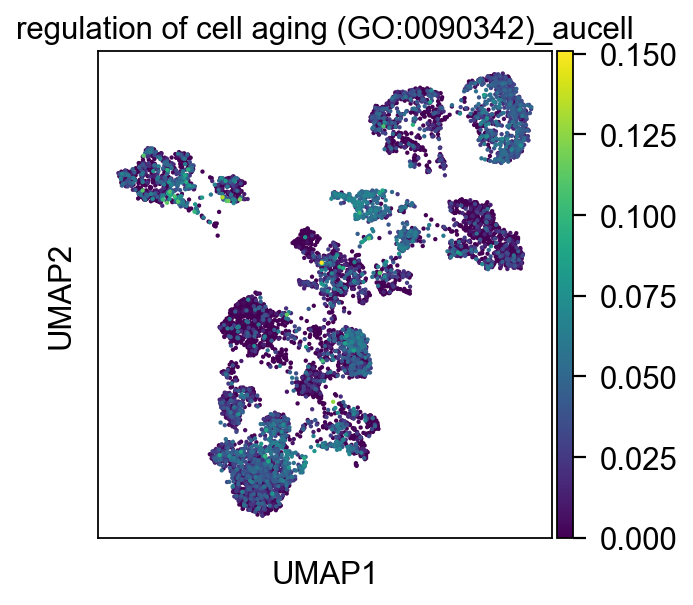

In [ ]:
##Assest one geneset
geneset_name='regulation of cell aging (GO:0090342)'
Pyomic.single.geneset_aucell(adata_raw,
                            geneset_name=geneset_name,
                            geneset=pathway_dict[geneset_name])
sc.pl.embedding(adata_raw,
                basis='umap',
          color=["{}_aucell".format(geneset_name)])

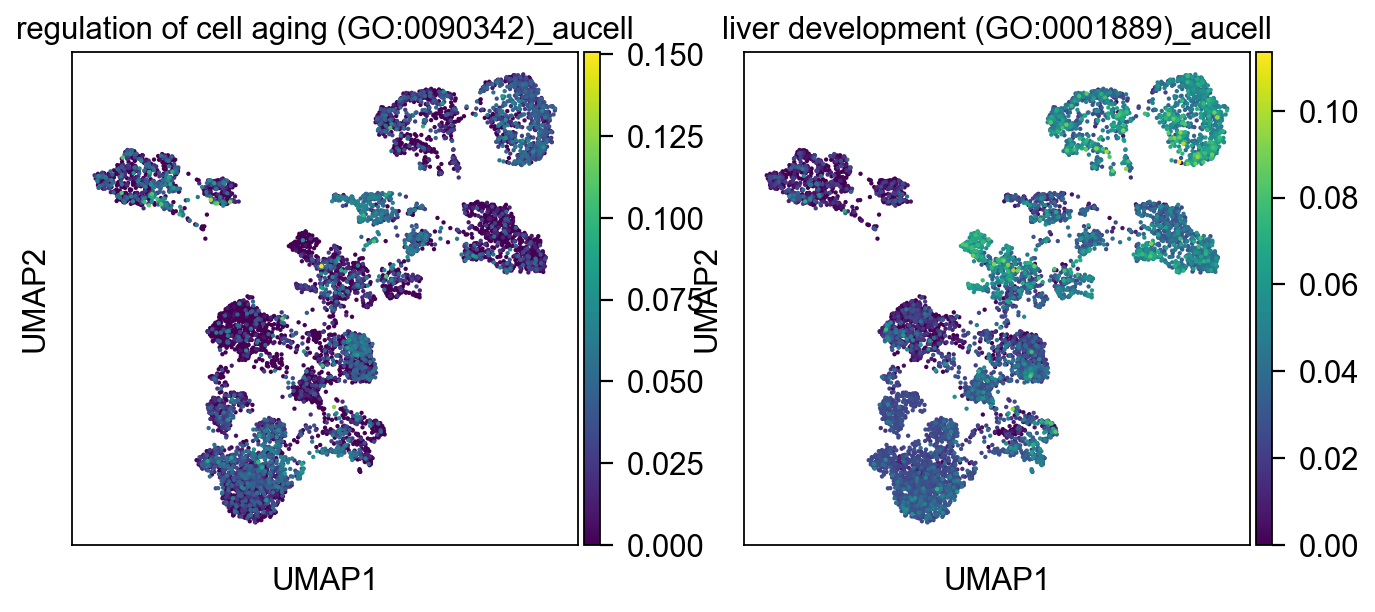

In [ ]:
##Assest more than one geneset
geneset_names=['regulation of cell aging (GO:0090342)','liver development (GO:0001889)']
Pyomic.single.pathway_aucell(adata_raw,
                            pathway_names=geneset_names,
                            pathways_dict=pathway_dict)
sc.pl.embedding(adata_raw,
                basis='umap',
          color=["regulation of cell aging (GO:0090342)_aucell","liver development (GO:0001889)_aucell"])

We can specify a set of genes we believe to be pathway enriched and visualize on the umap plot.



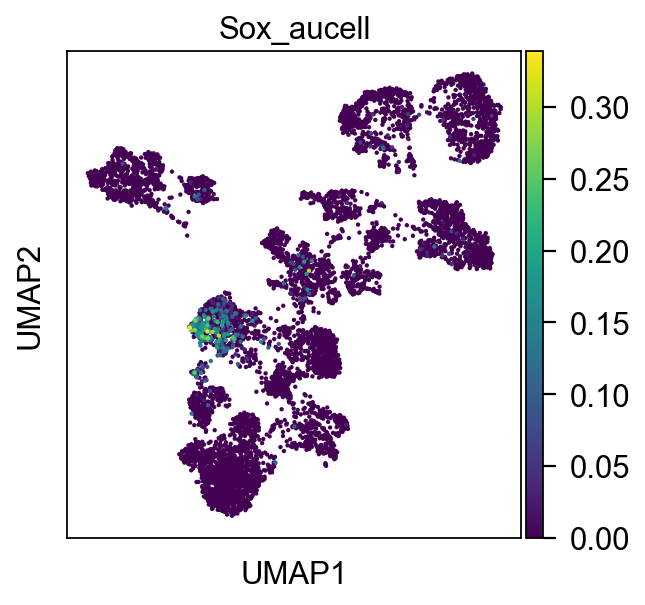

In [ ]:
##Assest test geneset
Pyomic.single.geneset_aucell(adata_raw,
                            geneset_name='Sox',
                            geneset=['Sox17', 'Sox4', 'Sox7', 'Sox18', 'Sox5'])
sc.pl.embedding(adata_raw,
                basis='umap',
          color=["Sox_aucell"])

We can perform enrichment analysis on all pathways in the database.


In [ ]:
##Assest all pathways
adata_aucs=Pyomic.single.pathway_aucell_enrichment(adata_raw,
                                                  pathways_dict=pathway_dict,
                                                  num_workers=8)
adata_aucs

Less than 80% of the genes in vesicle tethering to Golgi (GO:0099041) are present in the expression matrix.
Less than 80% of the genes in visual perception (GO:0007601) are present in the expression matrix.
Less than 80% of the genes in visual system development (GO:0150063) are present in the expression matrix.
Less than 80% of the genes in vitamin A metabolic process (GO:0006776) are present in the expression matrix.
Less than 80% of the genes in vitamin D metabolic process (GO:0042359) are present in the expression matrix.
Less than 80% of the genes in vitamin D3 metabolic process (GO:0070640) are present in the expression matrix.
Less than 80% of the genes in vitamin K metabolic process (GO:0042373) are present in the expression matrix.
Less than 80% of the genes in water transport (GO:0006833) are present in the expression matrix.
Less than 80% of the genes in wound healing, spreading of cells (GO:0044319) are present in the expression matrix.
Less than 80% of the genes in xenobio

AnnData object with n_obs × n_vars = 7848 × 6036

We can use the anndata class to store the resulting gene set pathway and visualize it using the functions provided by the anndata class.

In [ ]:
adata_aucs.obs=adata_raw[adata_aucs.obs.index].obs
adata_aucs.obsm=adata_raw[adata_aucs.obs.index].obsm
adata_aucs.obsp=adata_raw[adata_aucs.obs.index].obsp

In [ ]:
adata_aucs.write_h5ad('data/Mouse_single/liver_auce.h5ad',compression='gzip')

In [ ]:
adata_aucs=sc.read('data/Mouse_single/liver_auce.h5ad')

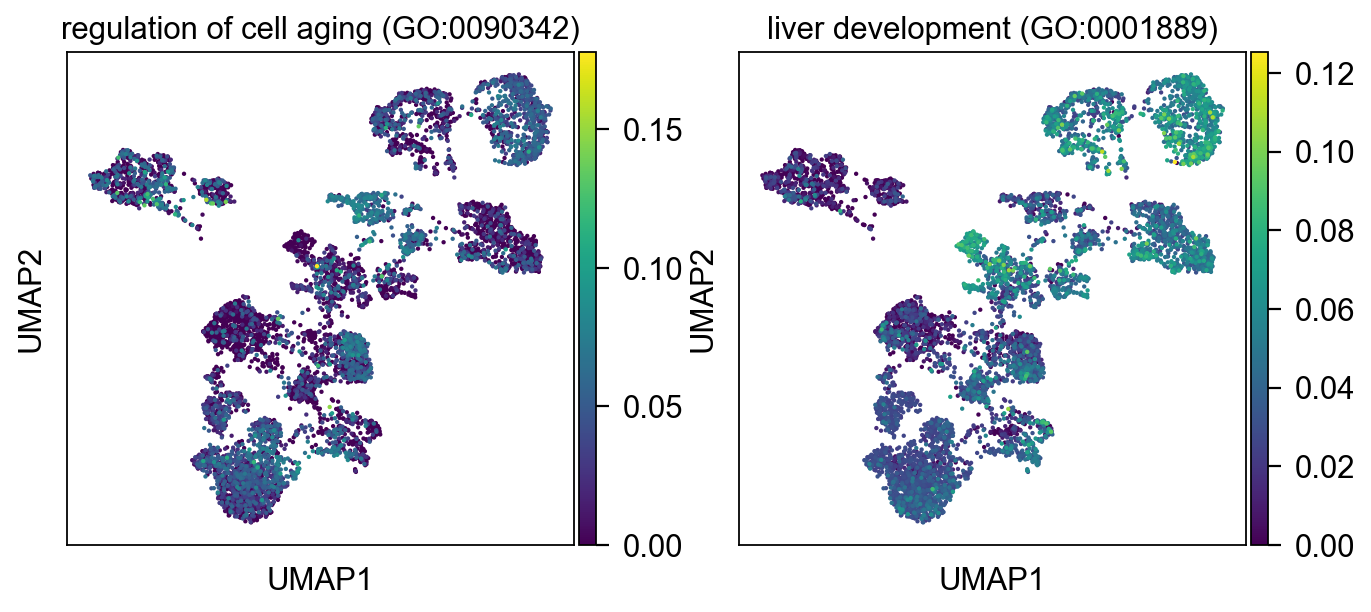

In [ ]:
sc.pl.embedding(adata_aucs,
                basis='umap',
          color=["regulation of cell aging (GO:0090342)","liver development (GO:0001889)"])

# Part3. Visualize differential enrichment pathways between different cell clusters.

Calculating and visualizing differential signal pathways.

In [ ]:
adata_aucs=sc.read('data/Mouse_single/liver_auce.h5ad')

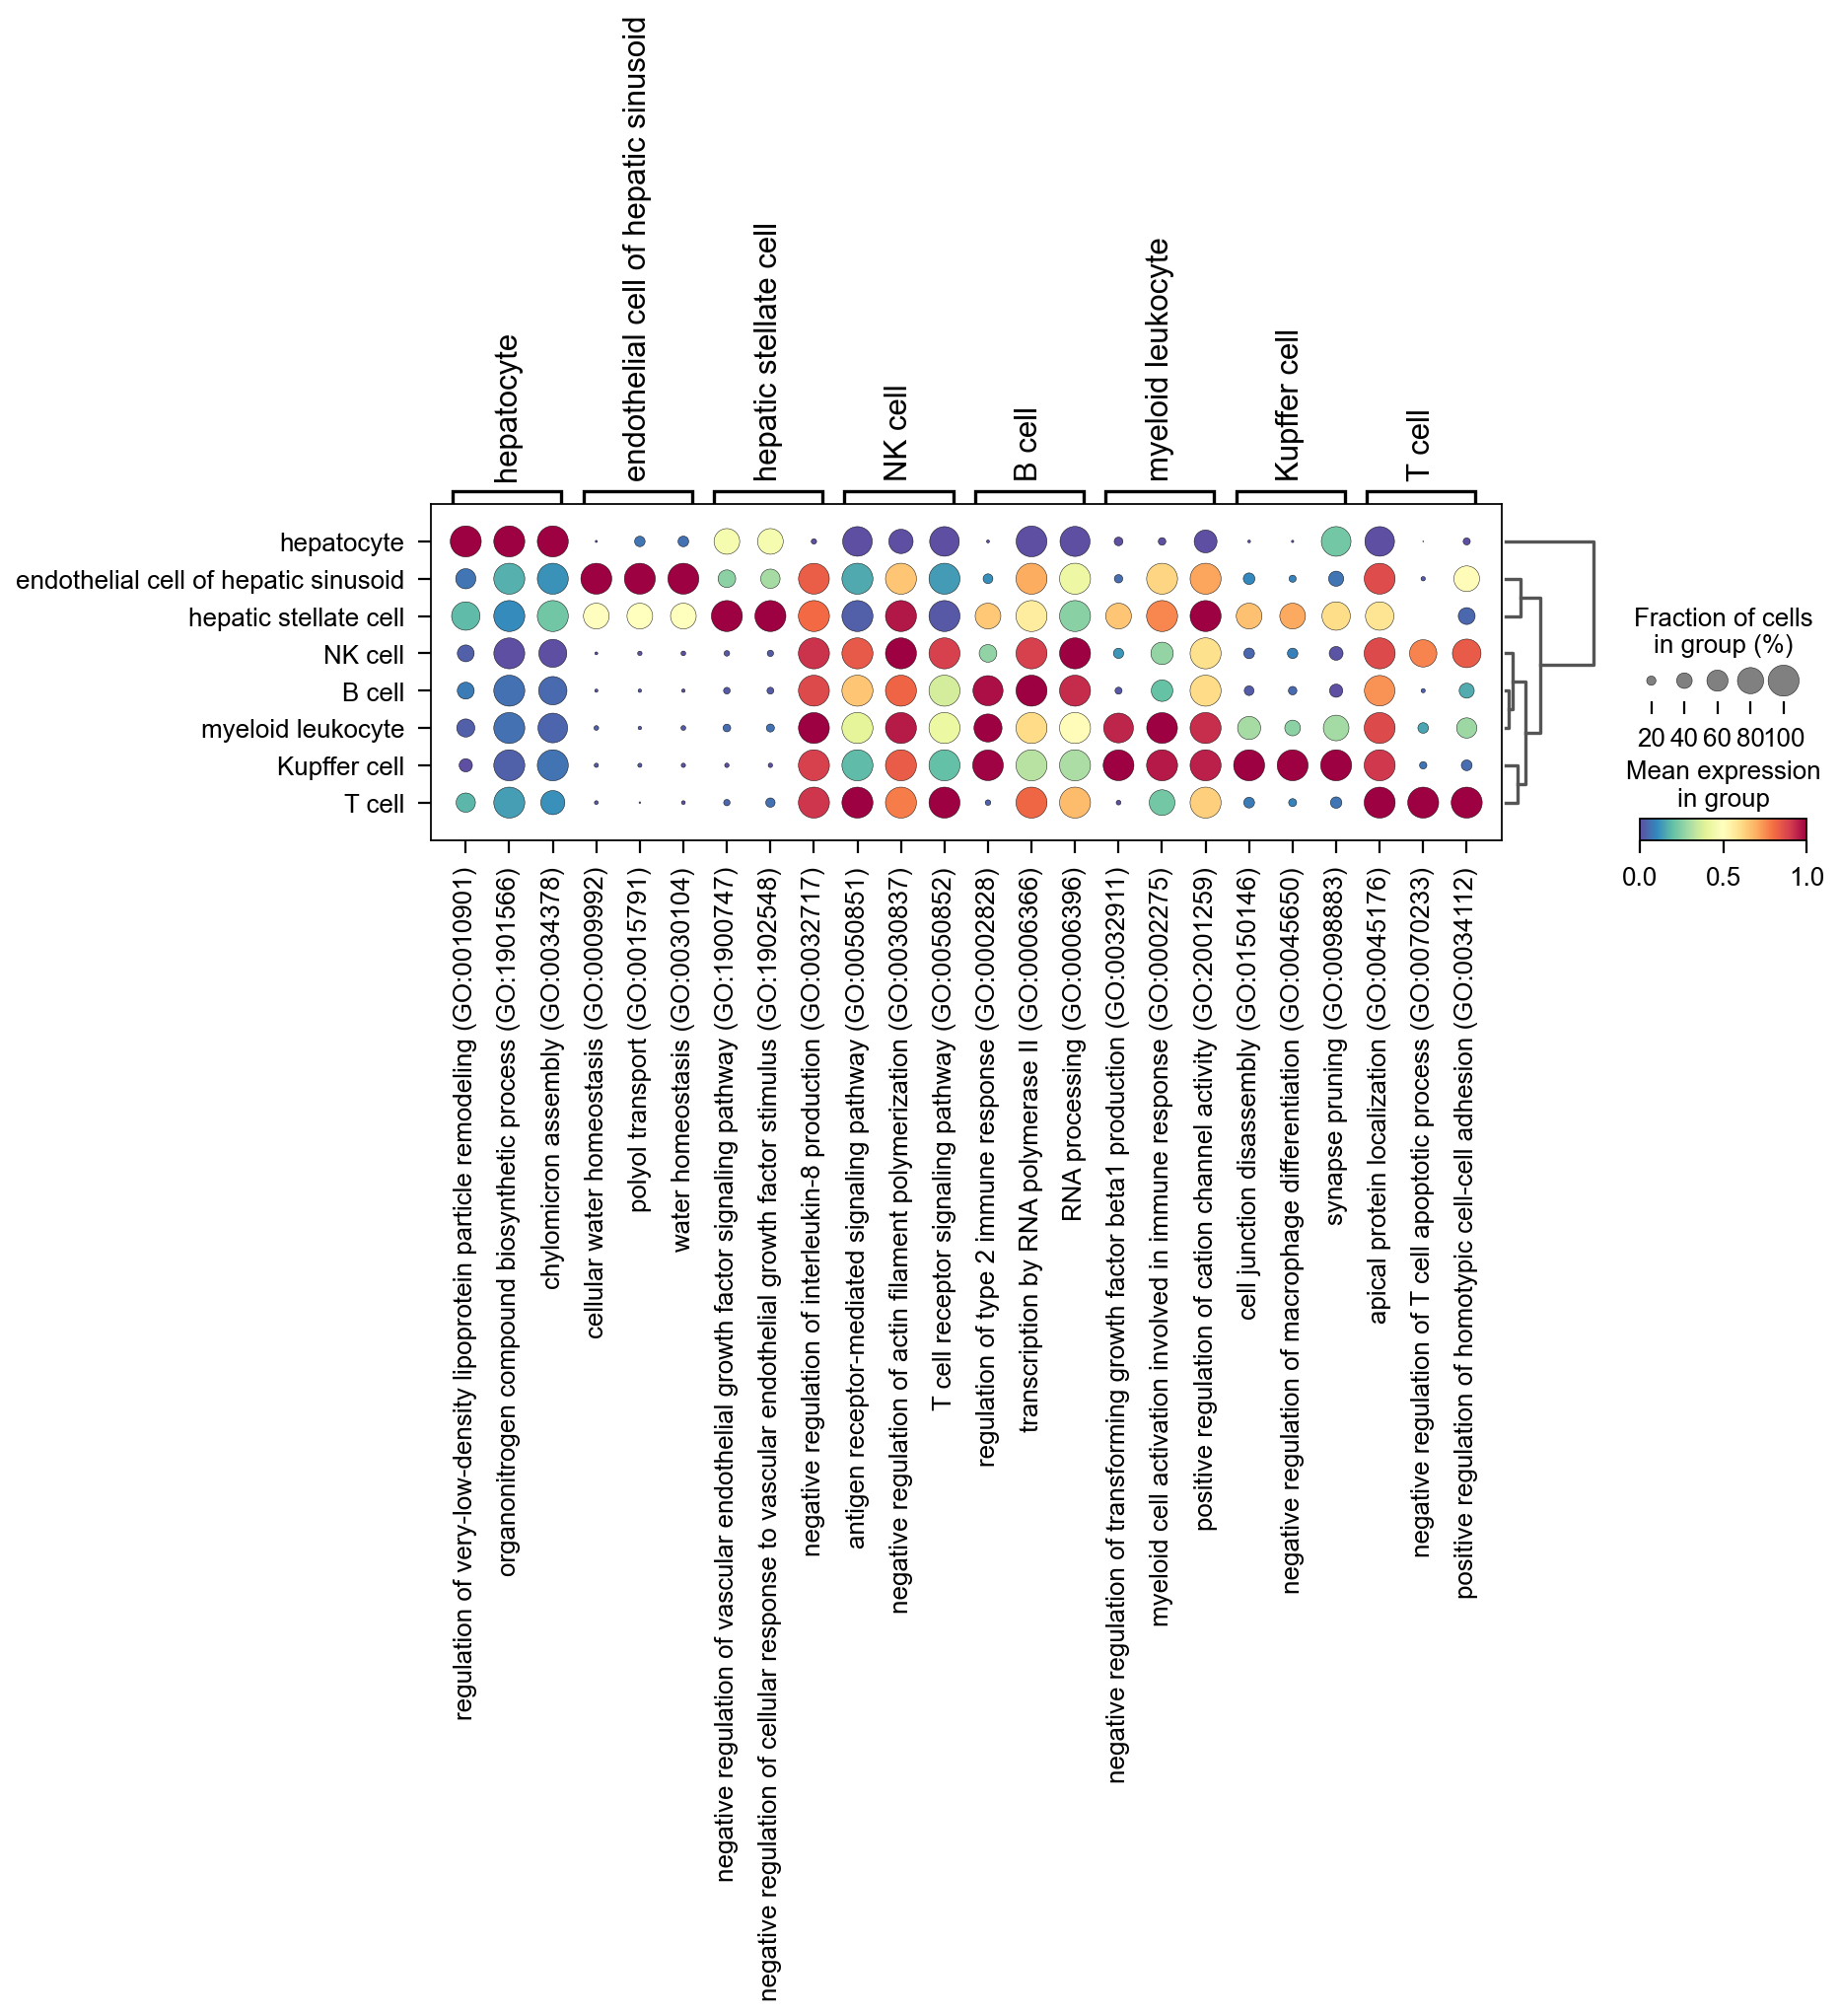

In [ ]:
#adata_aucs.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata_aucs, 'cell_ontology_class', method='t-test',n_genes=100)
sc.pl.rank_genes_groups_dotplot(adata_aucs,groupby='cell_ontology_class',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

Selecting pathways with significance based on manual thresholds.



In [ ]:
degs = sc.get.rank_genes_groups_df(adata_aucs, group='hepatocyte', key='rank_genes_groups', log2fc_min=4, 
                                    pval_cutoff=0.05)['names'].squeeze()
degs

0                   plasminogen activation (GO:0031639)
1     negative regulation of triglyceride metabolic ...
2                         lung development (GO:0030324)
3     regulation of triglyceride catabolic process (...
4               fructose catabolic process (GO:0006001)
5     fructose catabolic process to hydroxyacetone p...
6                             fibrinolysis (GO:0042730)
7     regulation of intestinal cholesterol absorptio...
8     positive regulation of triglyceride catabolic ...
9     secondary alcohol biosynthetic process (GO:190...
10     negative regulation of fibrinolysis (GO:0051918)
Name: names, dtype: object

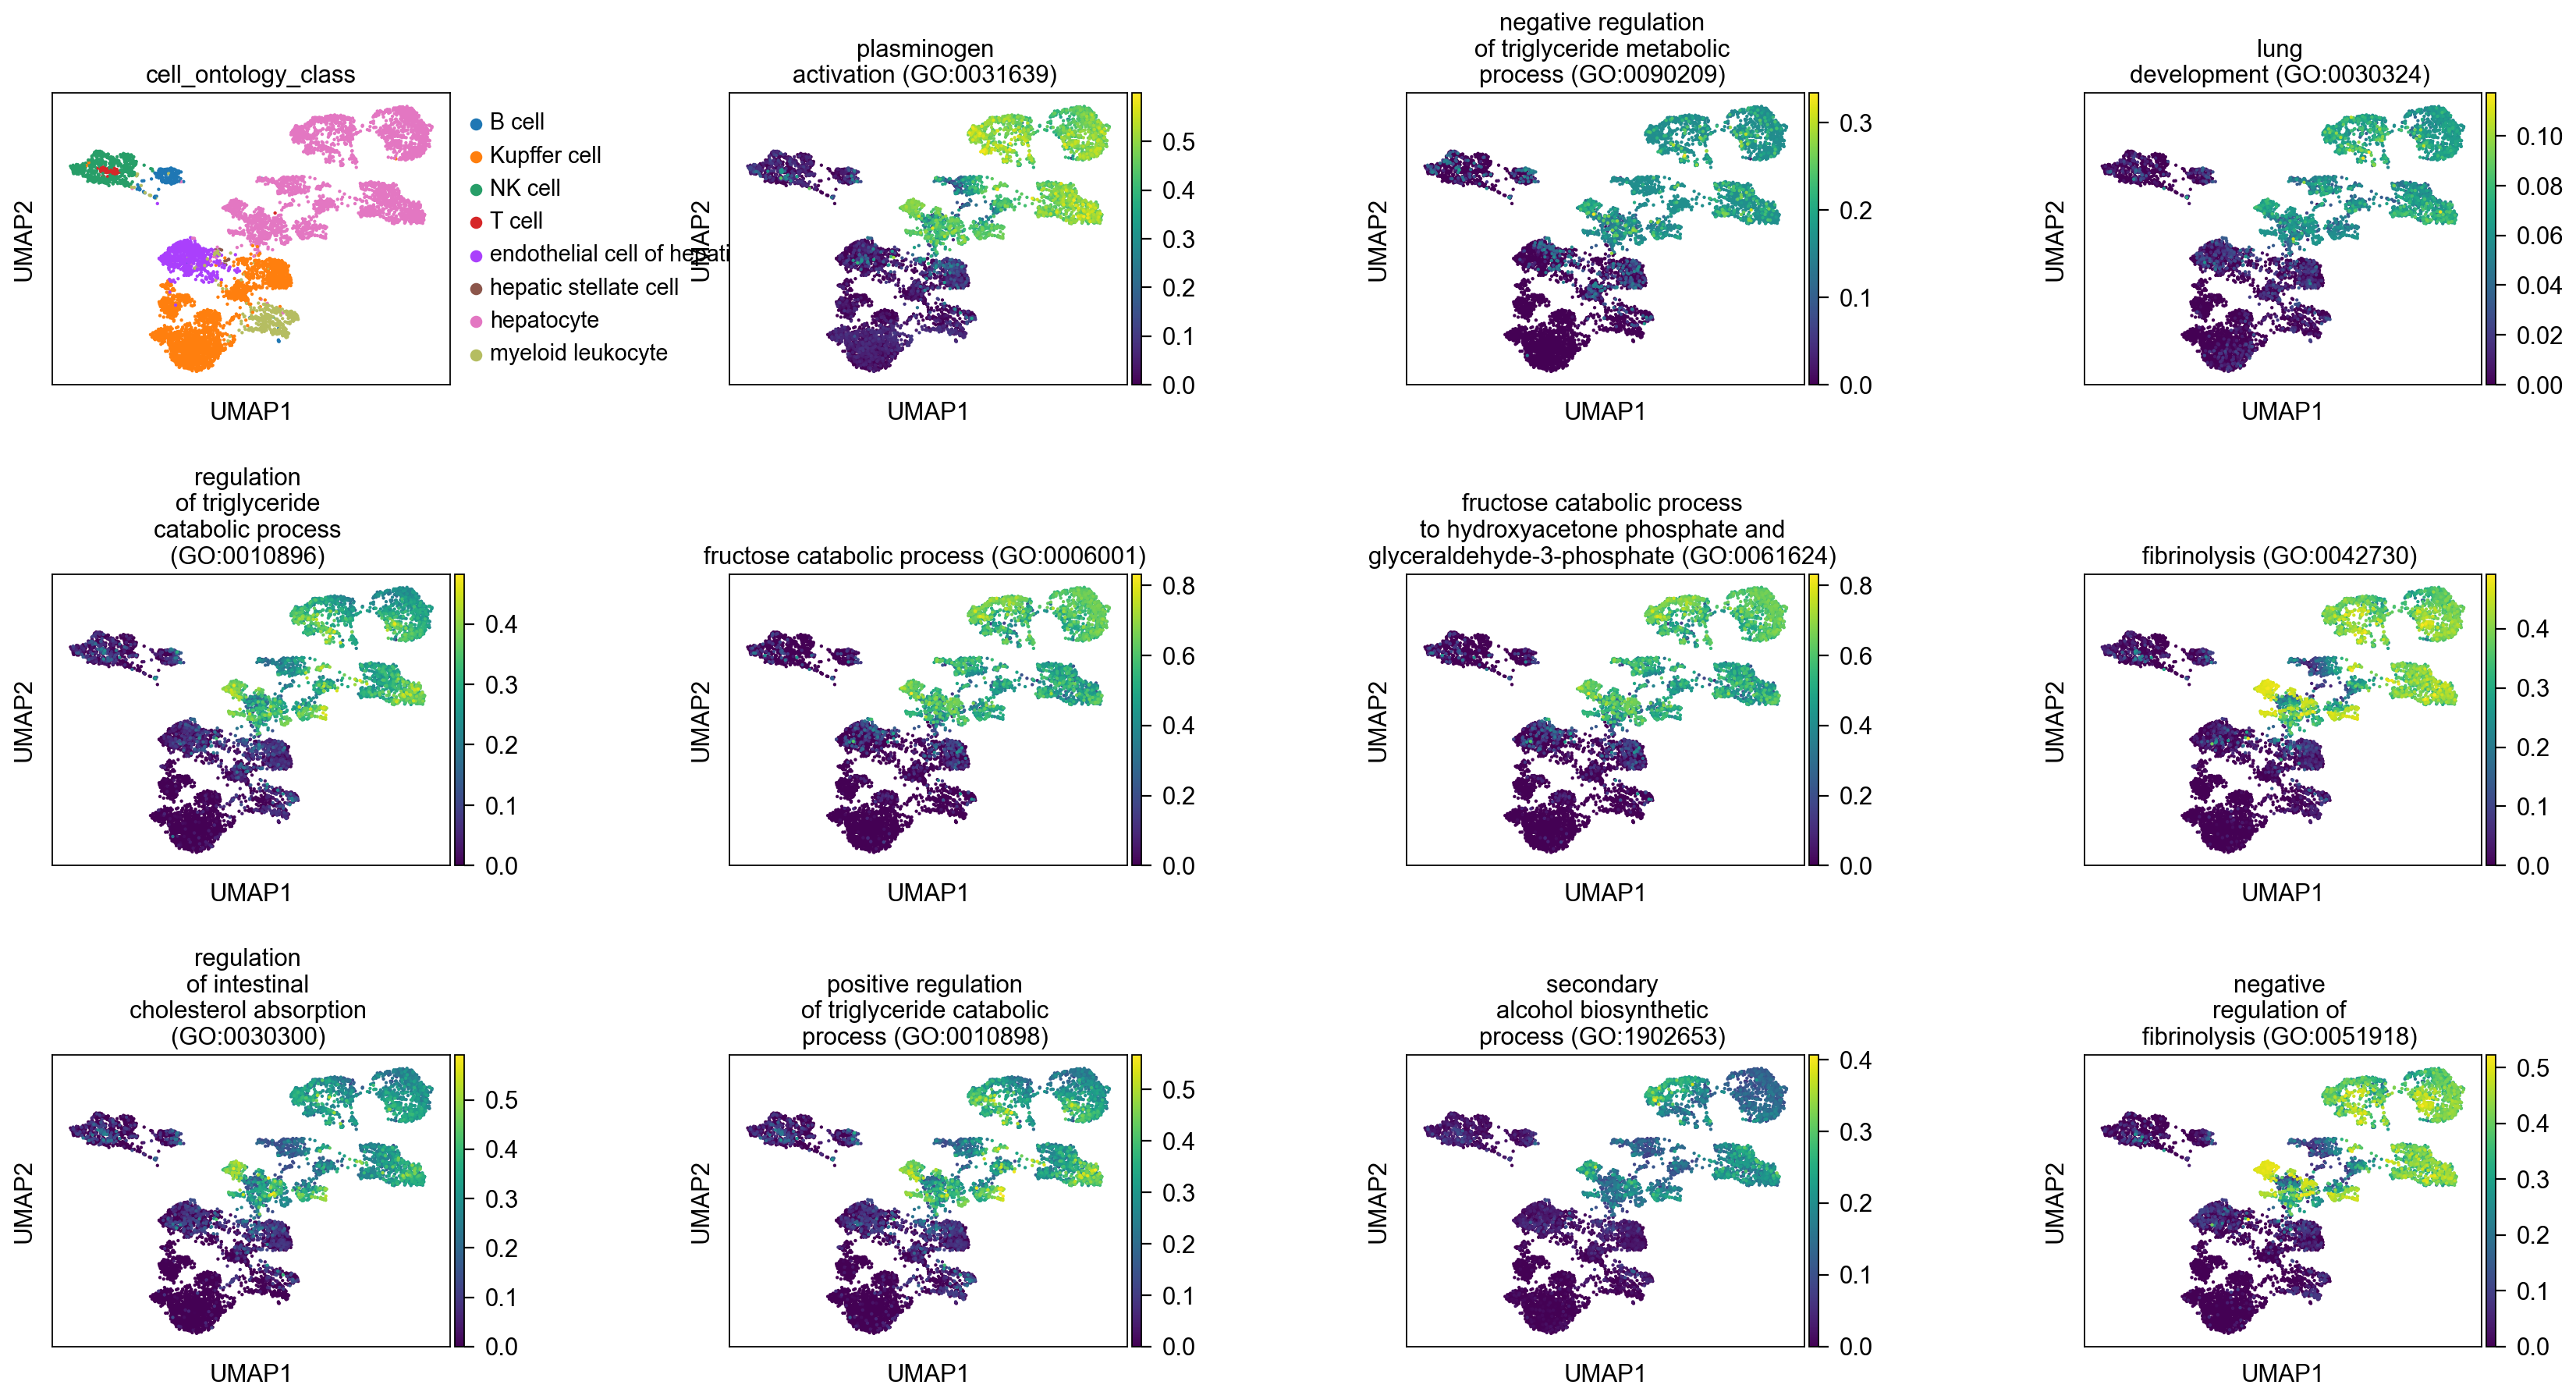

In [ ]:
import matplotlib.pyplot as plt
#fig, axes = plt.subplots(4,3,figsize=(12,9))
axes=sc.pl.embedding(adata_aucs,
                basis='umap',show=False,return_fig=True,wspace=0.55,hspace=0.65,
                color=['cell_ontology_class']+degs.values.tolist(),
                title=[Pyomic.utils.plot_text_set(i,3,20)for i in ['cell_ontology_class']+degs.values.tolist()])

axes.tight_layout()

In [ ]:
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, 'cell_ontology_class', method='t-test',n_genes=100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


Visualizing cell type specific pathways.

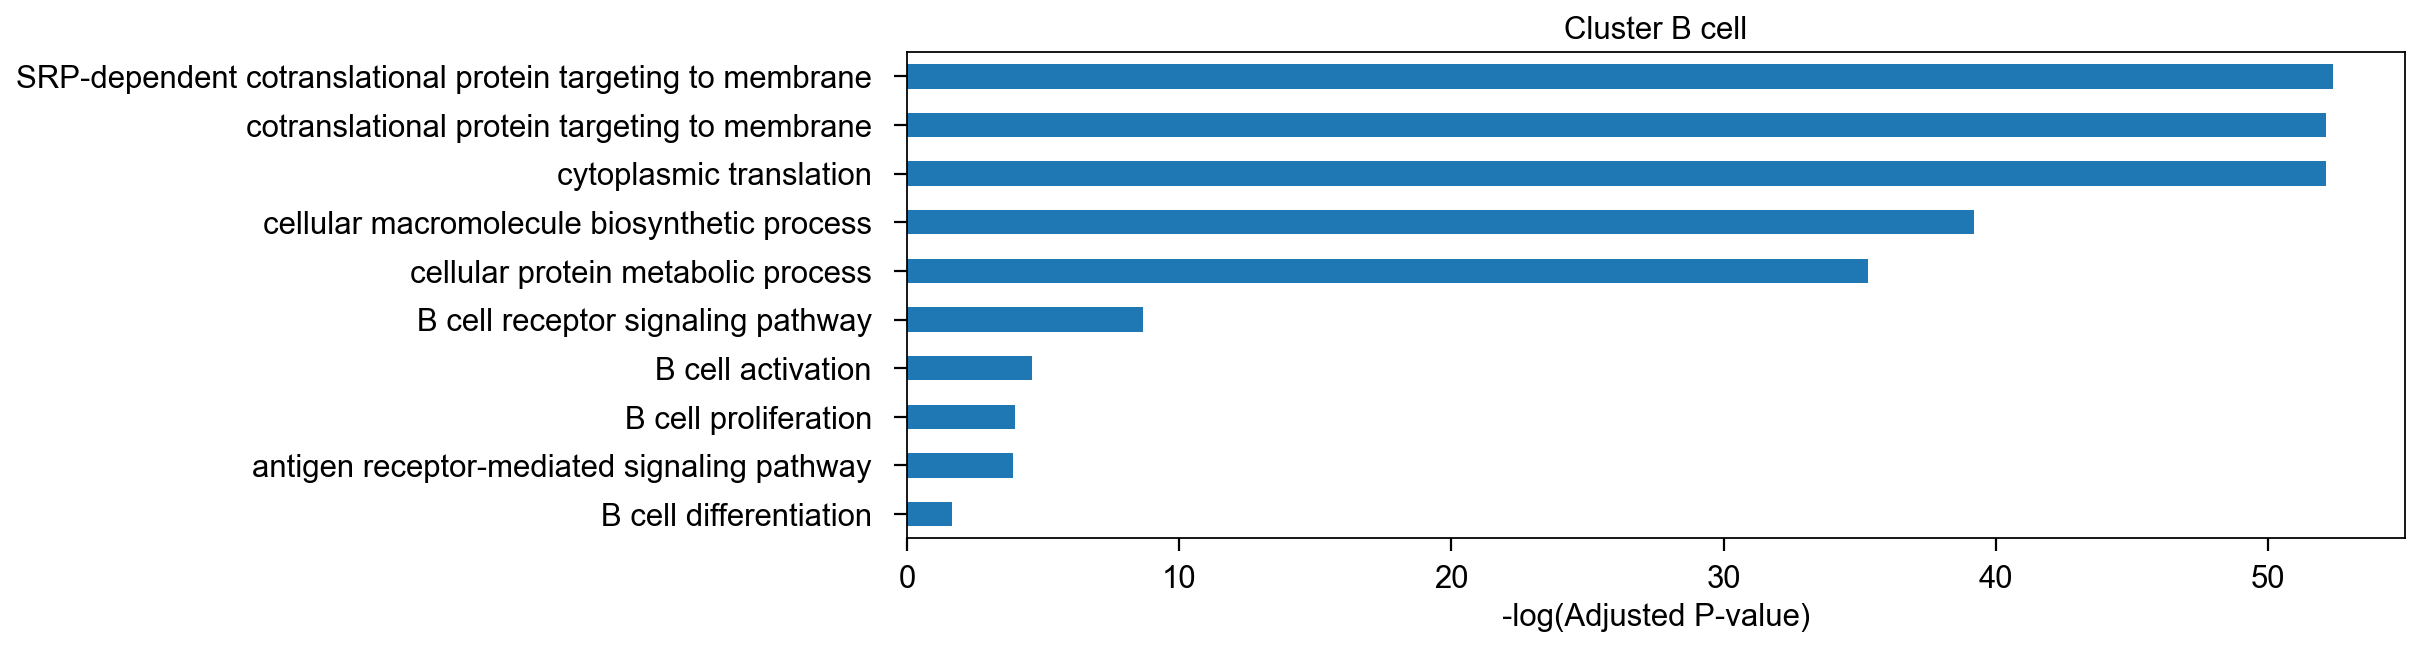

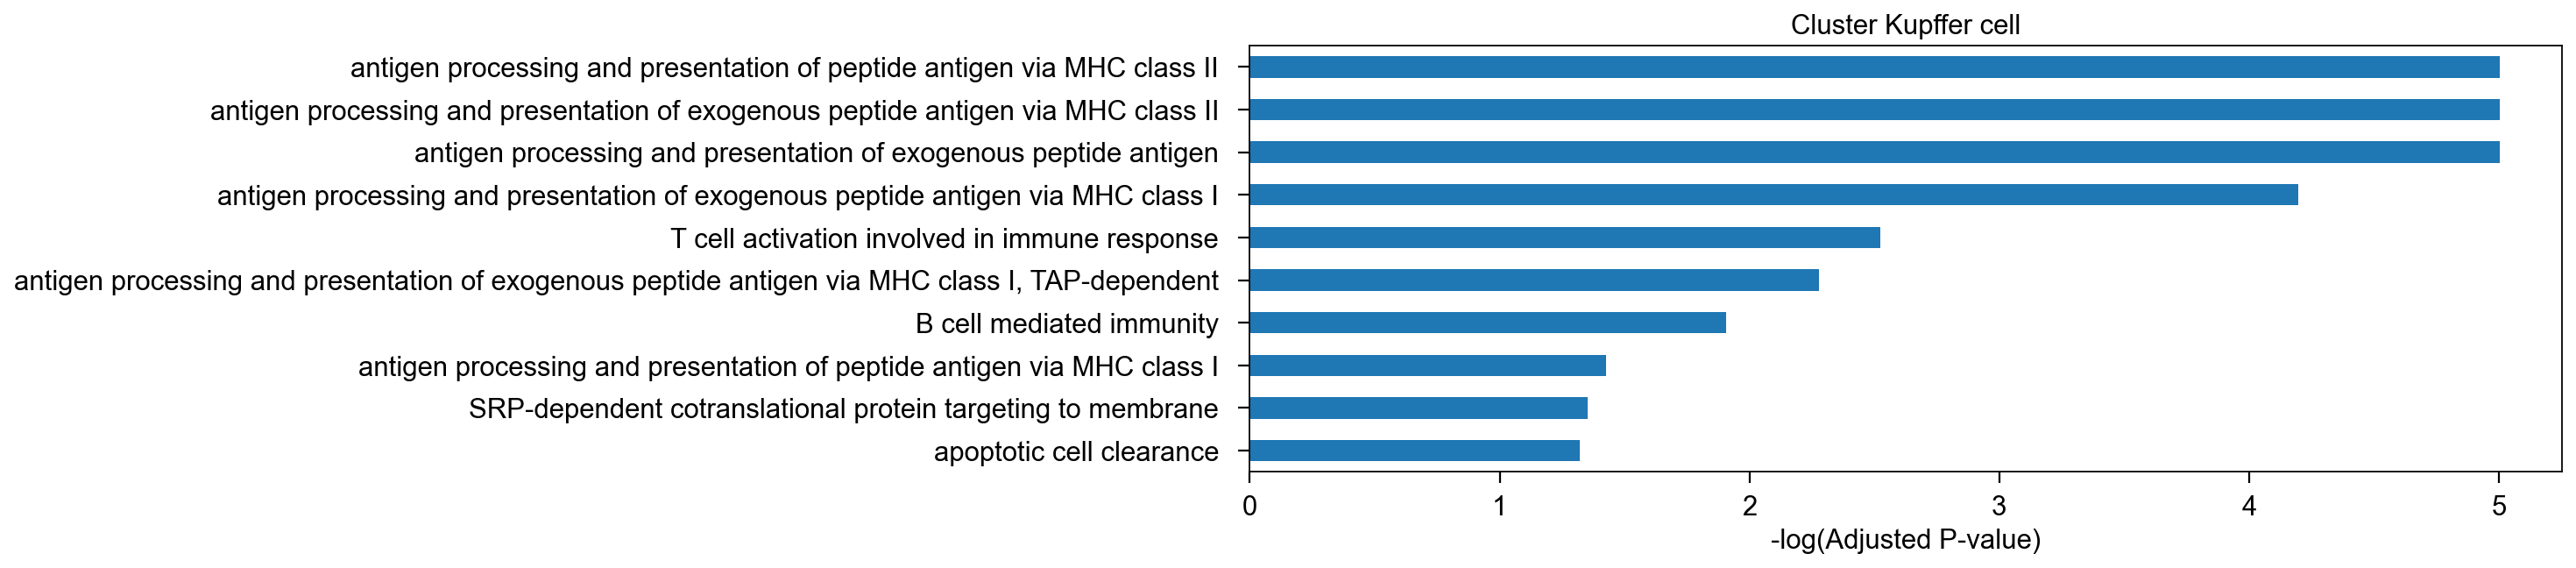

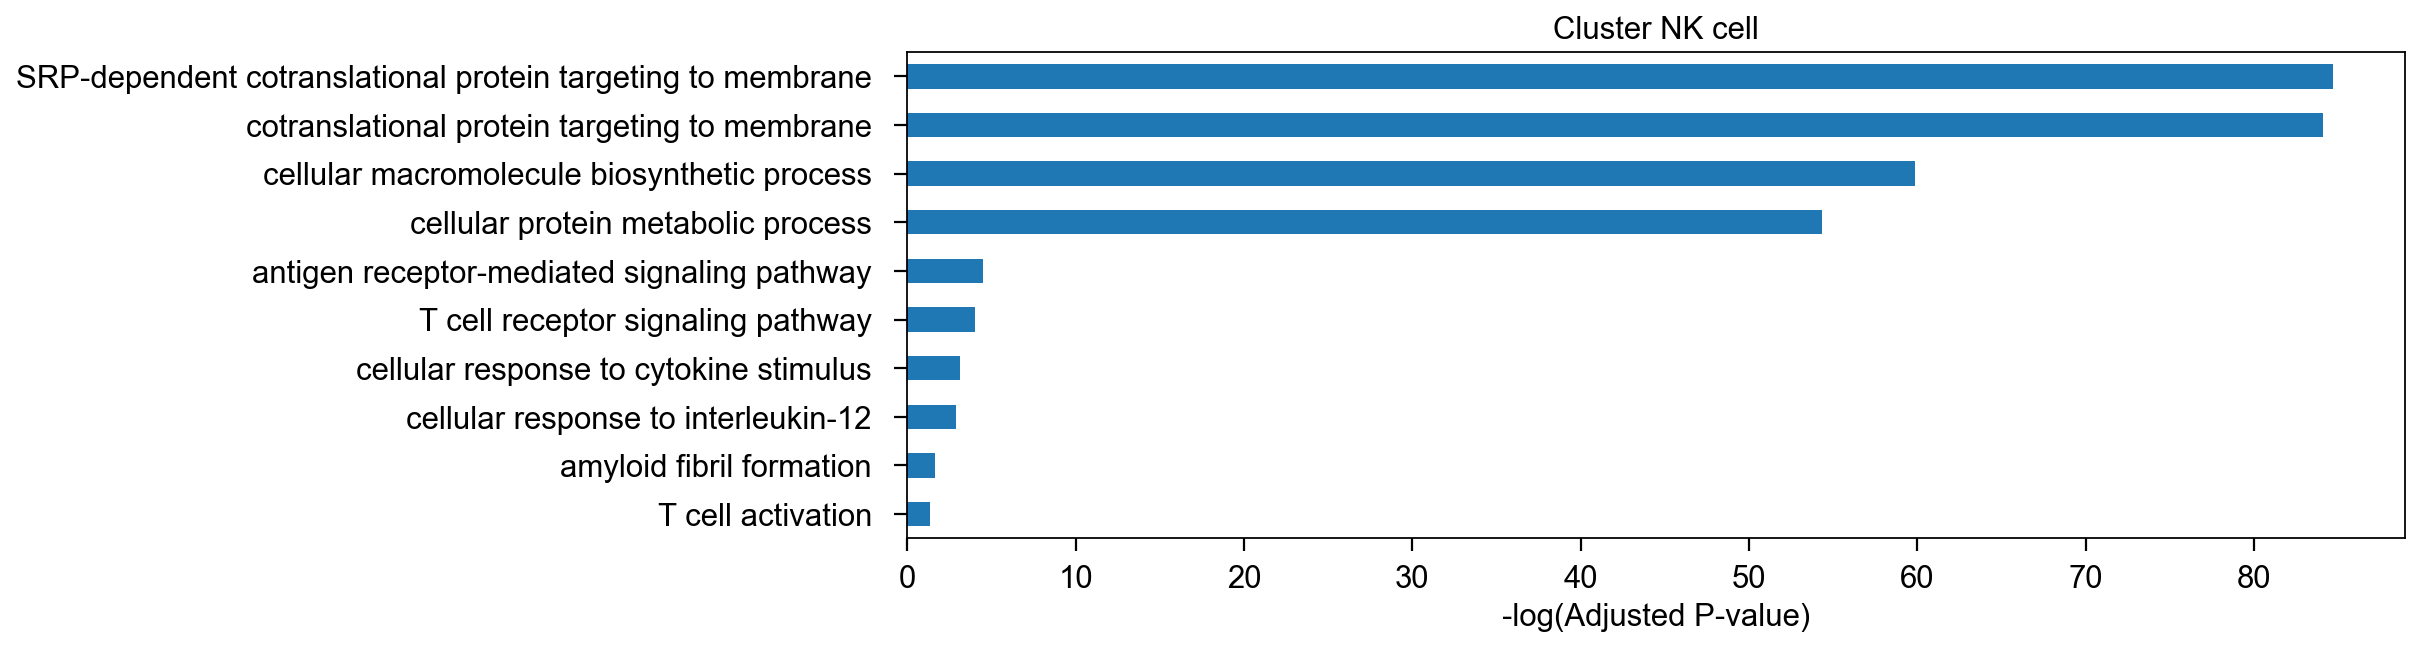

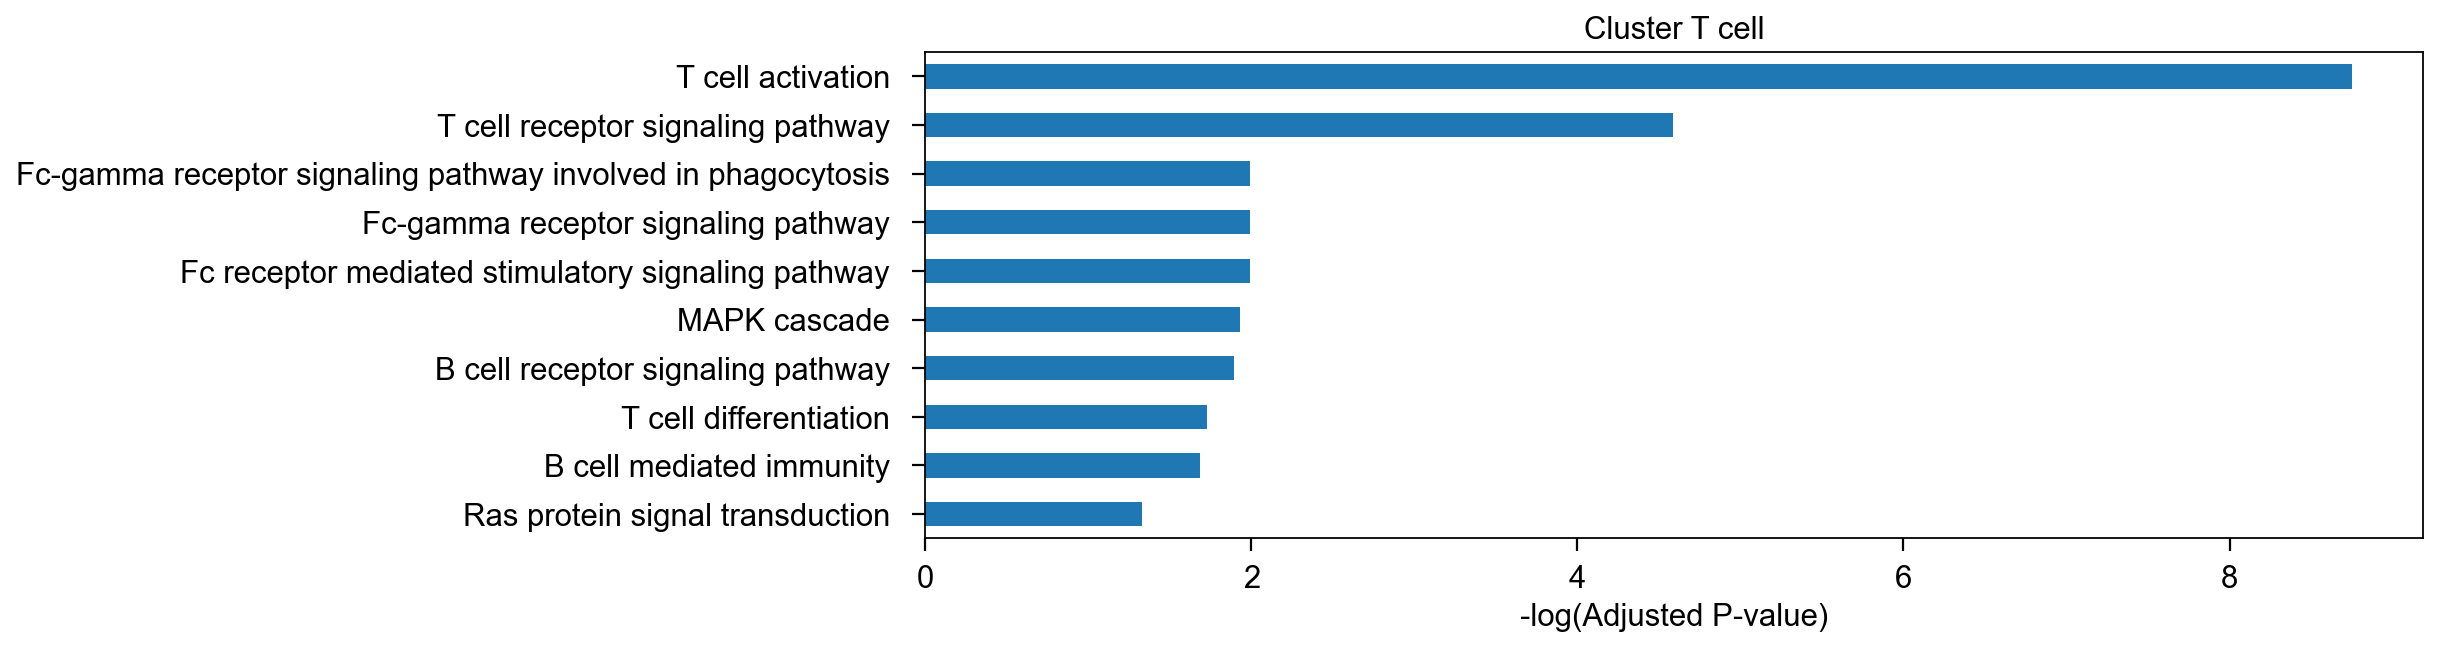

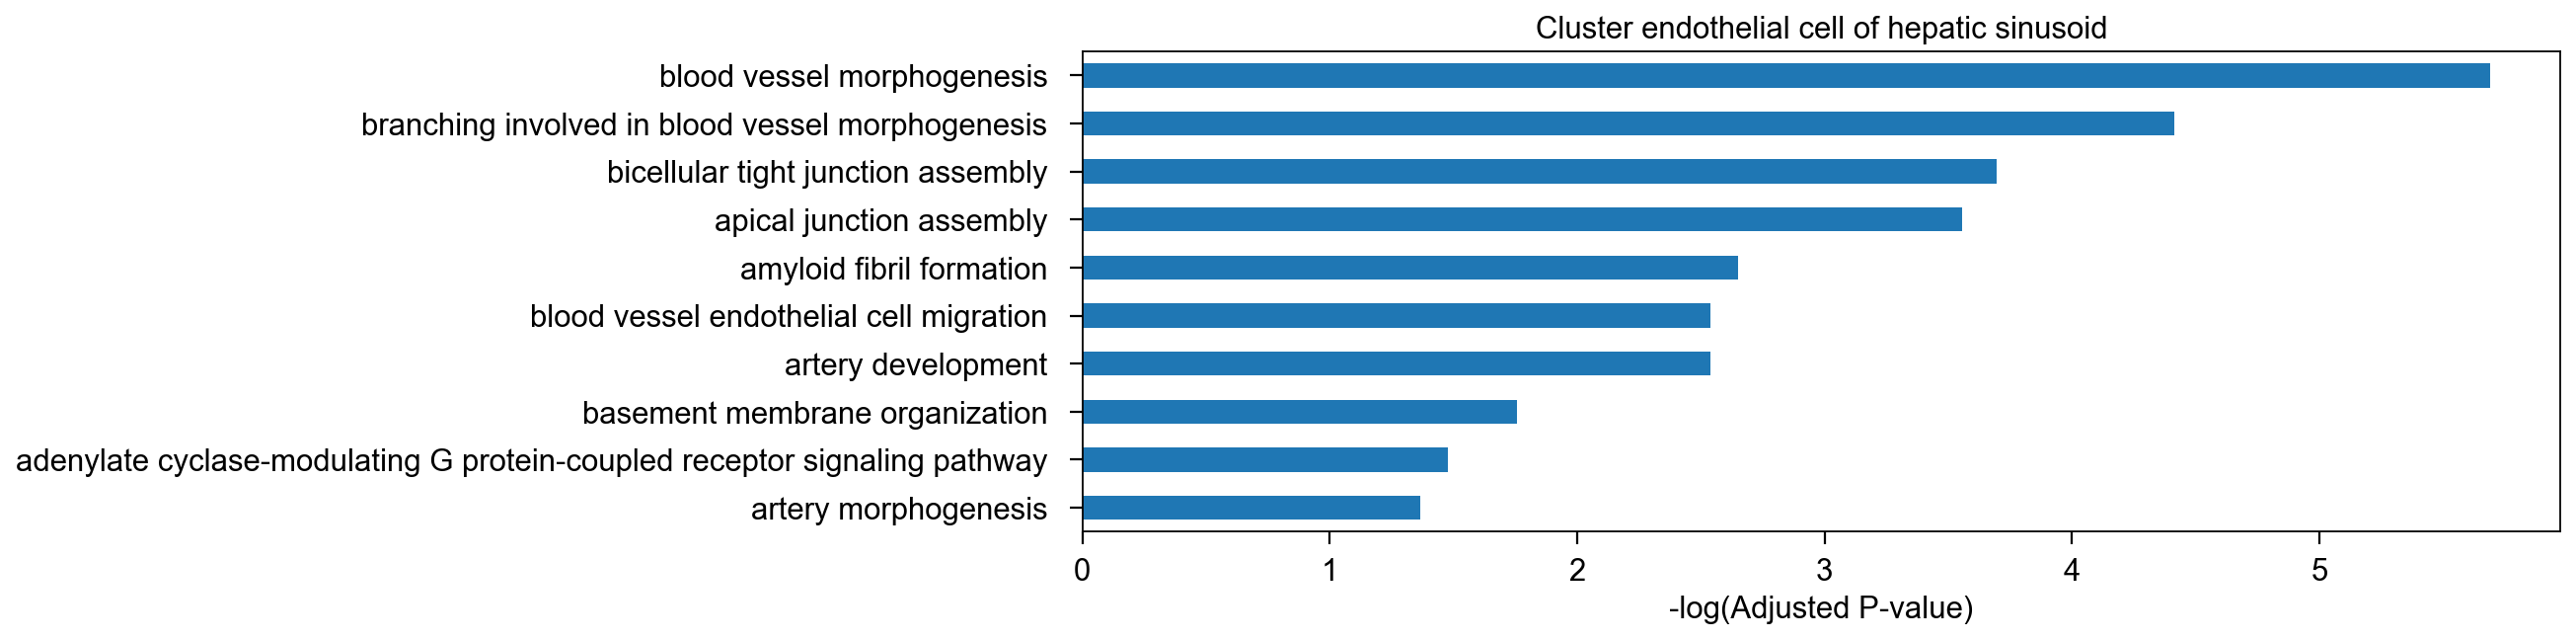

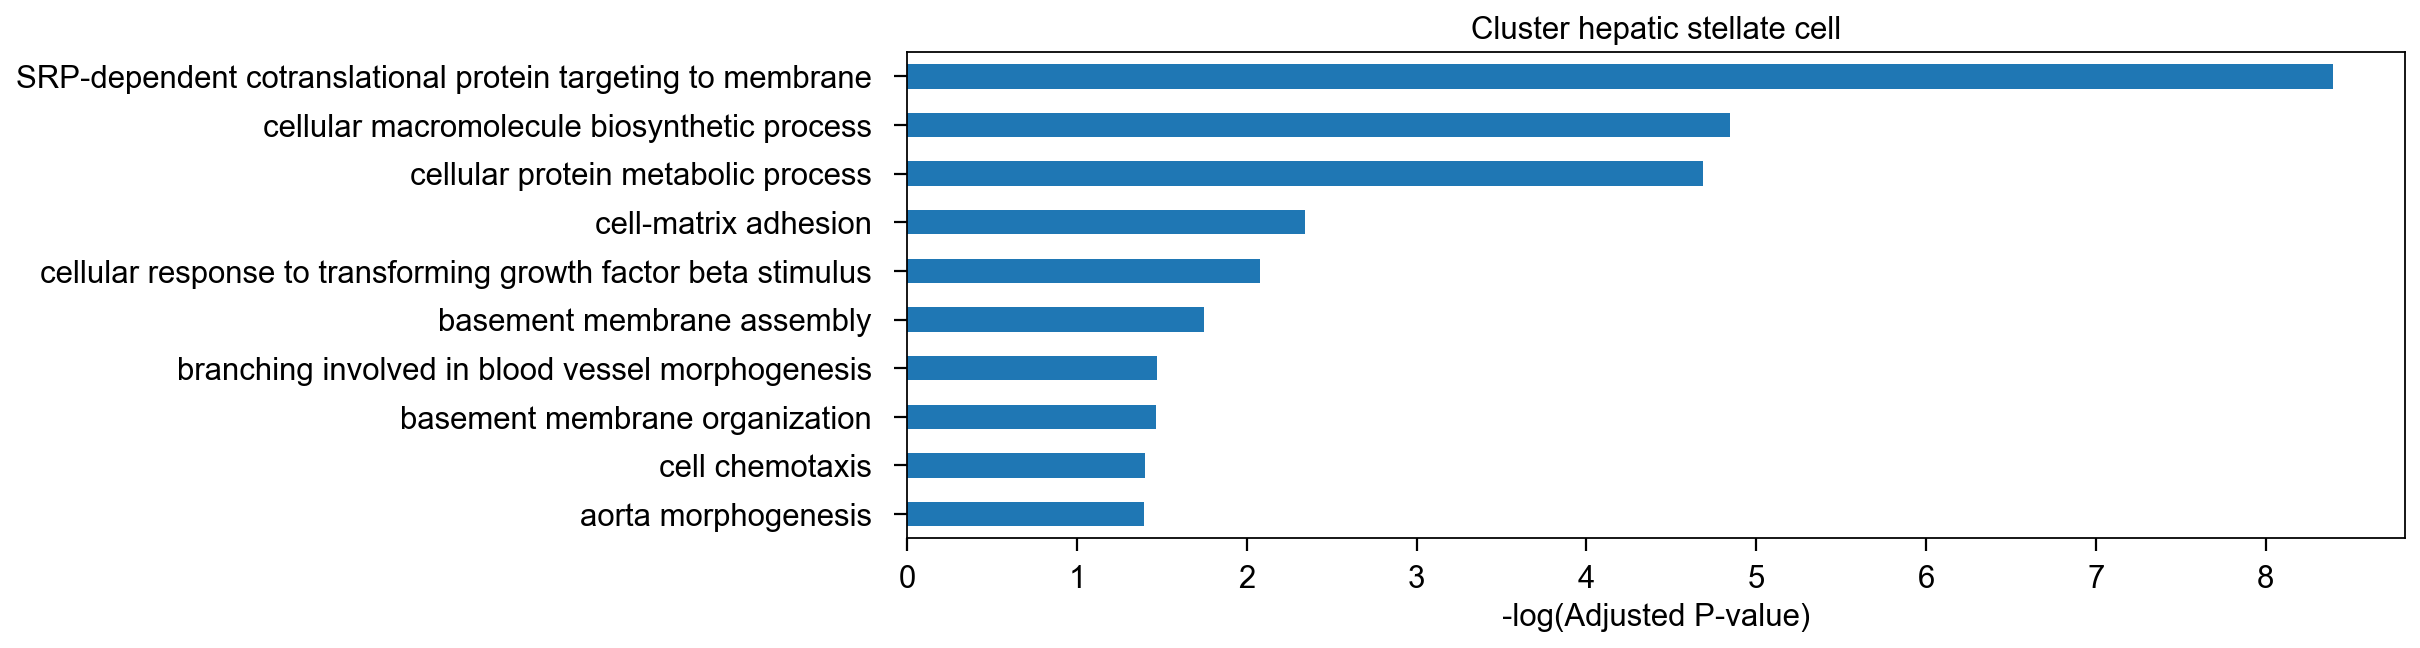

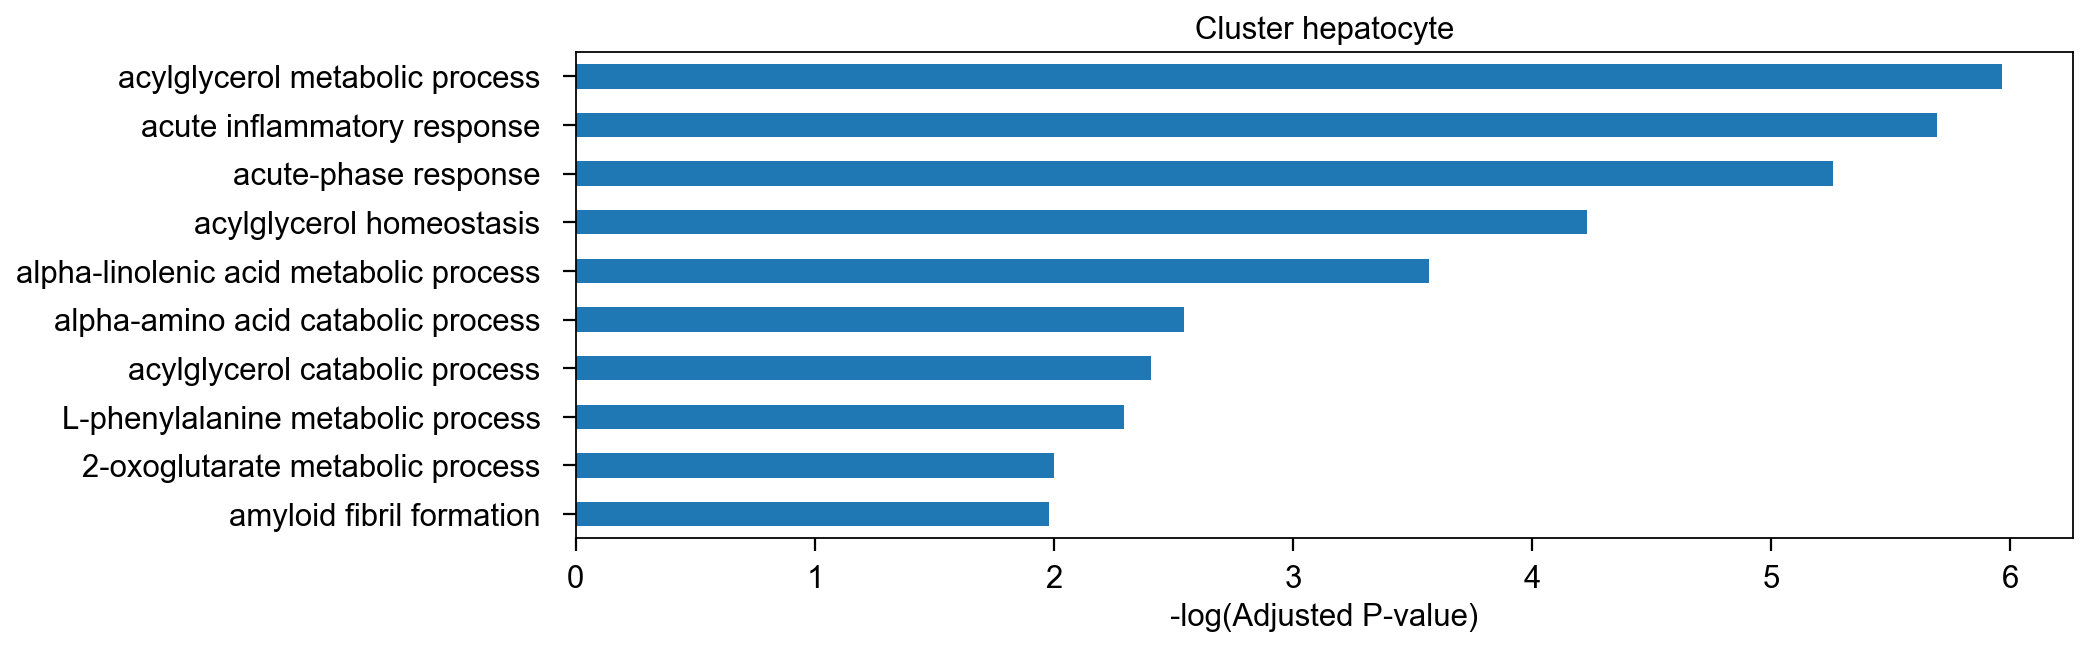

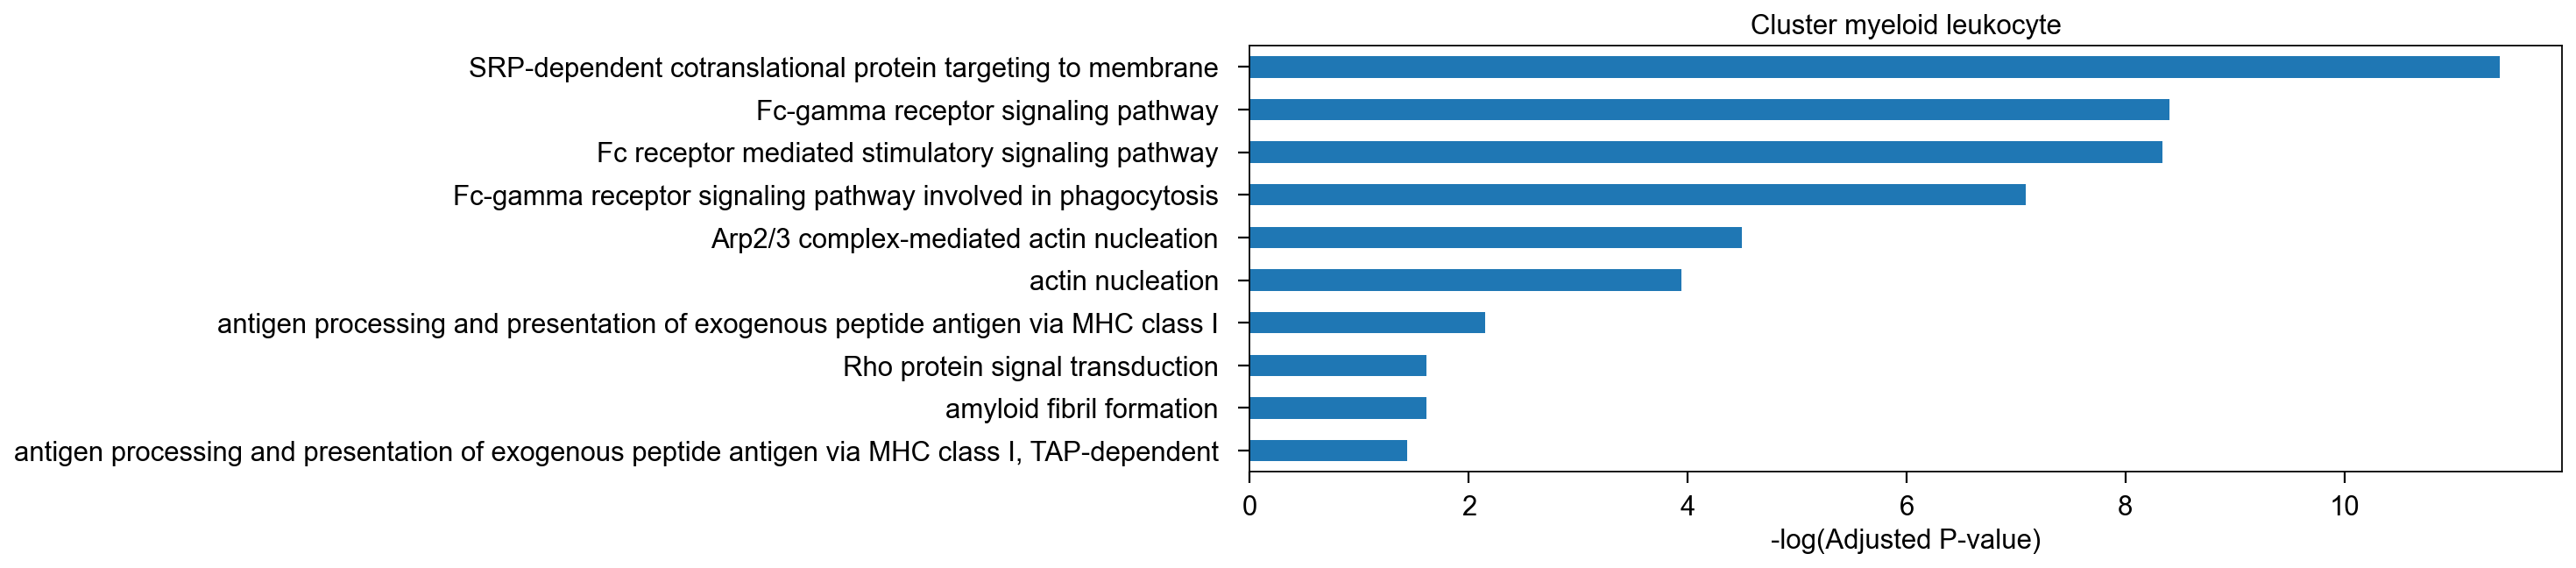

In [ ]:
res=Pyomic.single.pathway_enrichment(adata,pathways_dict=pathway_dict,organism='Mouse',
                                     group_by='cell_ontology_class',plot=True)

Visualizing differential pathways using heatmaps.

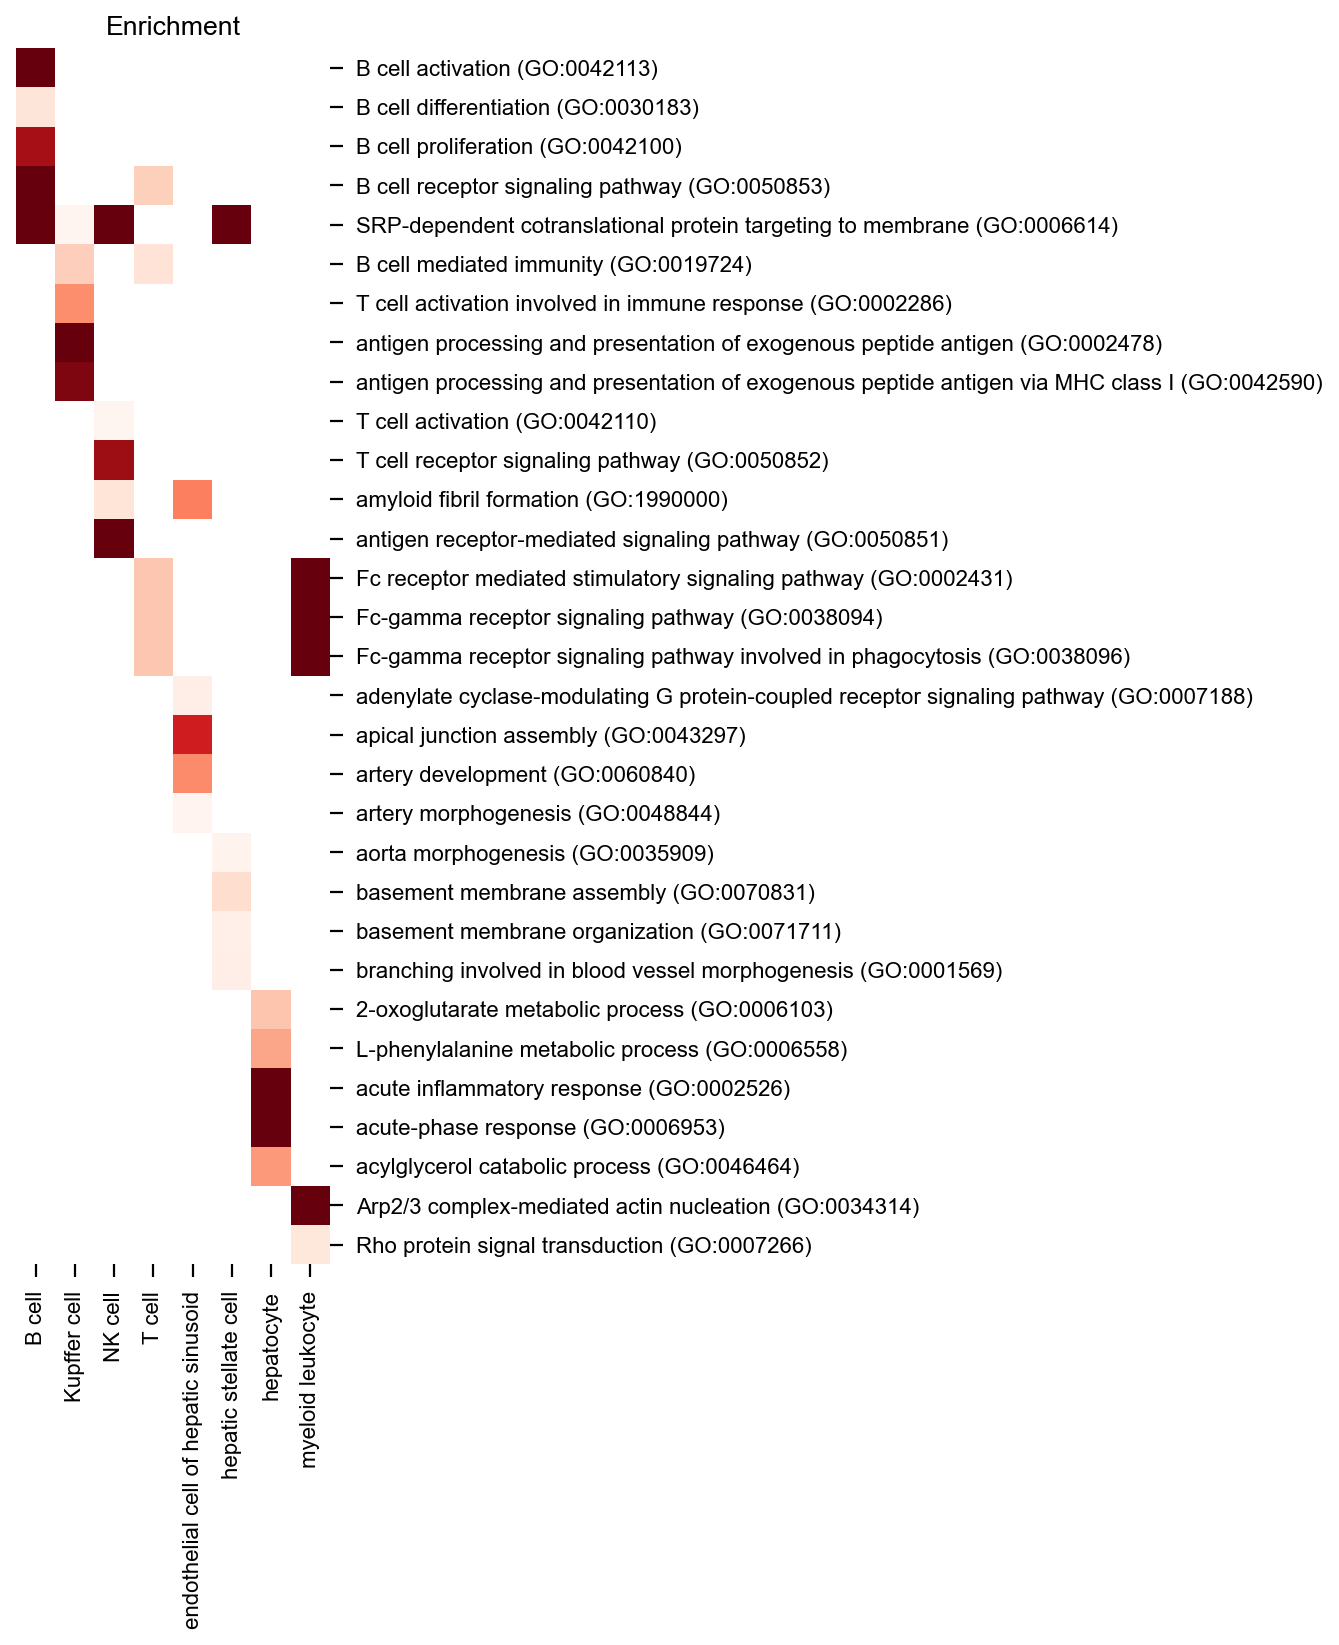

In [ ]:
ax=Pyomic.single.pathway_enrichment_plot(res,plot_title='Enrichment',cmap='Reds',
                                         xticklabels=True,cbar=False,square=True,vmax=10,
                                         yticklabels=True,cbar_kws={'label': '-log10(qvalue)','shrink': 0.5,})